In [7]:
import os
from datetime import datetime, timedelta
from geopandas import GeoDataFrame
import geopandas as gpd
import gpd_lite_toolbox as glt
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern
import pysal as ps
import shapely.speedups
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan
import shapely.geometry
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import contextily as ctx
import zipfile
from shapely.strtree import STRtree
from pointpats.centrography import std_distance
import pickle
import seaborn as sns

# sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
shapely.speedups.enable()
warnings.filterwarnings('ignore')
%matplotlib inline

In [22]:
plt.rcParams["figure.figsize"] = [8.0, 8.0]

In [ ]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [ ]:
def pip_count(points, polygon):
    try : 
        pips = points.within(polygon).value_counts()[True]
    except:
        pips = 0
    
    return pips

# Data Prep

In [ ]:
zf = '/Users/GeorgePyne/Documents/CASA/Digital Visualisation/Group Project/Foursquare_Data.zip'
csvs = [i for i in zipfile.ZipFile(zf).namelist() if str(i).endswith('csv')]
with zipfile.ZipFile(zf) as zipf:
    with zipf.open(csvs[0]) as myZip:
        df = pd.read_csv(myZip)

In [3]:
headers = ["User ID","Venue ID","Venue category ID","Venue category name","Longitude","Latitude","Timezone","UTC time"]
zf = '/Users/GeorgePyne/Downloads/dataset_tsmc2014.zip'
csvs = [i for i in zipfile.ZipFile(zf).namelist() if str(i).endswith('txt')]
with zipfile.ZipFile(zf) as zipf:
    with zipf.open(csvs[2]) as myZip:
        tk = pd.read_csv(myZip, encoding = "ISO-8859-1", names=headers, sep='\t')
        tk["UTC time"] = pd.to_datetime(tk["UTC time"])
        tk = tk.sort_values(by="UTC time")
        tk.index = tk["UTC time"]
        tk = tk.loc['2012-4-3':'2012-4-17']
        tk['geometry'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(tk.Latitude,tk.Longitude)]
        tk = GeoDataFrame(tk)
        tk.crs = {'init': 'epsg:4326'}
        tk = tk.to_crs(epsg=30177)
        tk.Latitude,tk.Longitude = tk.geometry.y, tk.geometry.x
        tk_base = tk['UTC time'][0]
        tk['time'] = tk['UTC time'] - tk_base
        tk = tk.sort_values(by='time')
        tk['time'] = tk['time'].apply(lambda x: (x.total_seconds() / 120)).astype(int)


In [4]:
with zipfile.ZipFile(zf) as zipf:
    with zipf.open(csvs[0]) as myZip:
            ny = pd.read_csv(myZip, encoding = "ISO-8859-1", names=headers, sep='\t')
            ny["UTC time"] = pd.to_datetime(ny["UTC time"])
            ny = ny.sort_values(by="UTC time")
            ny.index = ny["UTC time"]
            ny = ny.loc['2012-4-3':'2012-4-17']
            ny['geometry'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(ny.Latitude,ny.Longitude)]
            ny = GeoDataFrame(ny)
            ny.crs = {'init': 'epsg:4326'}
            ny = ny.to_crs(epsg=2263)
            ny.Latitude,ny.Longitude = ny.geometry.y, ny.geometry.x
            ny_base = ny['UTC time'][0]
            ny['time'] = ny['UTC time'] - ny_base
            ny = ny.sort_values(by='time')
            ny['time'] = ny['time'].apply(lambda x: (x.total_seconds() / 120)).astype(int)

In [10]:
print(len(ny))
print(len(tk))

21884
37739


In [ ]:
ny.tail(5)[['User ID', 'geometry']]#.to_file(save_test)

In [ ]:
tk.groupby('Venue category name').count().sort_values(by='User ID', ascending=False).head(20)[['User ID']]

In [ ]:
ny.groupby('Venue category name').count().sort_values(by='User ID', ascending=False).head(20)[['User ID']]

In [ ]:
xmin, ymin, xmax, ymax = ny.total_bounds

In [20]:
xmin, ymin, xmax, ymax = tk.total_bounds
x_extent, y_extent = (xmax - xmin), (ymax - ymin)
Hs = (x_extent+y_extent)/2
Hs = Hs / 4
Ht = int(tk.time.max()/4)
Hs_M = int(Hs*0.3048)

In [6]:
x_extent, y_extent = (xmax - xmin), (ymax - ymin)

In [19]:
Hs = (x_extent+y_extent)/2
Hs = Hs / 4
Ht = int(ny.time.max()/4)
Hs_M = int(Hs*0.3048)

NameError: name 'ny' is not defined

In [21]:
print(f'Spatial search area for NYC was {Hs_M} metres * {Hs_M} metres * {Ht*2} hours')

Spatial search area for NYC was 3033 metres * 3033 metres * 5124 hours


In [ ]:
tk_base = tk['UTC time'][0]
tk['time'] = tk['UTC time'] - tk_base
tk = tk.sort_values(by='time')
tk['time'] = tk['time'].apply(lambda x: (x.total_seconds() / 10)).astype(int)
xmin, ymin, xmax, ymax = tk.total_bounds


In [22]:
def decomp_preperation(df):
    """Prepares the data for ST decomposition in XYT format"""
    filename = input('Filename? ')
    directory = "/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/files/"+filename
    df[['Longitude','Latitude','time']].to_csv(directory,header=False,index=False)
    xmin, ymin, xmax, ymax = df.total_bounds
    zmin, zmax = df.time.min(), df.time.max()
        
    src = open(directory,"r")
    fline = '{0},{1},{2},{3},{4},{5}\n'.format(xmin,xmax,ymin,ymax,zmin,zmax)
    oline = src.readlines()
    oline.insert(0,fline)
    src.close()
    
    src=open(directory,"w")
    src.writelines(oline)
    src.close()

In [23]:
decomp_preperation(tk)

Filename? TK_april.txt


# Spatiotemporal Decomposition

In [24]:
Rs = Hs/2
Rt = Ht/2

In [25]:
#import modules
from datetime import datetime
import sys, os
import decomposition as decomp, settings as sett
import shutil

#set recursion limit
sys.setrecursionlimit(8000)

#initialize global variables
sett.init()
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#read parameters
pFile = open('files/parameterFile.txt', "r")
pFile.readline()
pList = pFile.readline().split("\t")

sett.p1 = float(pList[0])	# p1 = spatial bandwidth
sett.p2 = float(pList[1])	# p2 = temporal bandwidth
sett.p3 = float(pList[2])	# p3 = spatial resolution
sett.p4 = float(pList[3])	# p4 = temporal resolution
sett.p5 = float(pList[4])	# p5 = number of points threshold (T1)
sett.p6 = float(pList[5])	# p6 = buffer ratio threshold (T2)


sett.p1 = float(Hs)
sett.p2 = float(Ht)
sett.p3 = float(Rs)
sett.p4 = float(Rt)



#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#create output directory
sett.dir1 = 'pointFiles'
sett.dir2 = 'timeFiles'


if os.path.exists(sett.dir1):
    shutil.rmtree(sett.dir1)
os.makedirs(sett.dir1)

if os.path.exists(sett.dir2):
    shutil.rmtree(sett.dir2)
os.makedirs(sett.dir2)


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#read input point file
# pFile = open('files/NY_april.txt', "r")
pFile = open('files/TK_april.txt', "r")
inX, inY, inZ = [], [], []
r = pFile.readline().split(",")
xmin, xmax, ymin, ymax, zmin, zmax = float(r[0]), float(r[1]), float(r[2]), float(r[3]), float(r[4]), float(r[5].strip())

for record in pFile:   
    inX.append(float(record.split(",")[0]))
    inY.append(float(record.split(",")[1]))
    inZ.append(float(record.split(",")[2]))
    
pFile.close()
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#start decomposition
startTime = datetime.now()
decomp.decompose(inX, inY, inZ, xmin, xmax, ymin, ymax, zmin, zmax)
endTime = datetime.now()

#record decomposition time
runTime = endTime - startTime 
print("Decomposition into {0} files in {1}.".format(len(os.listdir('pointFiles')), runTime))
tFile=open('timeFiles/decomp_time.txt', "w")
tFile.write(str(runTime))
tFile.close()
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Decomposition into 512 files in 0:00:27.905947.


In [ ]:
print(f'{Rs} {Rt}')

In [ ]:
print(f'{Hs} - {Rs} - {Ht} - {Rt}')

In [ ]:
directory = '/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/pointFiles'
total = len(ny)
subdomain_total = 0
for filename in os.listdir(directory):
    txt = pd.read_csv(directory+'/'+filename, skiprows=1, names=['lon','lat','time']) # read decomp
    subdomain_total = subdomain_total + len(txt)
print(f'total = {total} subdomain total = {subdomain_total}')

# Methodology

In [2]:
def lm_to_df(lm):
        lm_moves = pd.DataFrame({"Transitions":lm.transitions.flatten(), "Expected":lm.expected_t.flatten()}) 
        lm_moves['Transitions'] = lm_moves['Transitions'].astype(int)
        lm_moves.index = ["HH-HH","HH-LH","HH-LL","HH-HL", # Make index 16 possible move types
                  "LH-HH","LH-LH","LH-LL","LH-HL",
                  "LL-HH","LL-LH","LL-LL","LL-HL",
                  "HL-HH","HL-LH","HL-LL","HL-HL"]
        lm_moves['Residuals'] = lm_moves.Transitions - lm_moves.Expected # Calculate difference of observed - expected
        
        
        return lm_moves

### Create base time stamp and add hours into index

In [27]:
def create_index(cluster_times, cluster_geometries):
    
    """Creates a key-value pair global-local time-space index 
    with time as the key lookup and values are individual STR-trees"""
    
    lookup = {} # create dict for key-value lookup
    for ct, cg in zip(cluster_times, cluster_geometries):
        if ct in lookup: # Check if STR-tree is drawn for t
            lookup[ct] = STRtree(lookup[ct]._geoms+[cg]) # Redraw STR_tree if record exists
        else:
            lookup[ct] = STRtree([cg]) # Create STR-tree from geometry list
            
    return lookup

# index = create_index(moving_frame_t, moving_frames)

In [5]:
def mc_poly_gdf(index):
    times,geometries = [],[]
    for t, g in index.items():
            geoms = g._geoms
            geoms = [shape for shape in geoms if type(shape) == shapely.geometry.polygon.Polygon]
            geoms = [shapely.geometry.Polygon(zip(geom.exterior.coords.xy[1],geom.exterior.coords.xy[0])) for geom in geoms]
            if len(geoms) > 1: 
                geometries.append(shapely.geometry.MultiPolygon(geoms))
                times.append(t)
            elif geoms:
                geometries.append(geoms[0])
                times.append(t)
        
    mc_poly_gdf = GeoDataFrame({'time':times, 'geometry':geometries})
    return mc_poly_gdf
    
        

In [ ]:
dac = [215, 430, 310, 233, 271, 345, 304, 29, 418, 372, 299, 59, 232, 21, 41, 395, 289, 289, 15, 480, 272, 37, 26, 14, 29, 13, 226, 320, 35, 345, 21, 244, 297, 290, 452, 84, 266, 327, 304, 9, 267, 35, 7, 30, 196, 255, 399, 25, 256, 36, 330, 269, 35, 653, 311, 315, 87, 389, 202, 12, 15, 28, 18, 180, 40, 225, 8, 264, 277, 283, 17, 19, 241, 447, 10]
plt.plot([i for i in range(1,(len(dac)+1))],dac)
plt.xlabel('Subdomains (not CSR)');
plt.ylabel('Time (seconds)');

In [322]:
def extract_moving_cluster_object(data, str_tree):
    results = []
    data['geometry_query'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(data.Latitude,data.Longitude)]
    for geom,time in zip(data['geometry_query'],data['time']):   
        try:
            result = str_tree[time].query(geom)
            if result:
                results.append(True)
            else:
                results.append(False)
        except:
            results.append(False)
    data['Intersect'] = results
    data = data.drop('geometry_query',axis=1)
    data = data.loc[data['Intersect']==True].drop('Intersect', axis=1)
    
    return data

In [ ]:
ny_mcs = extract_moving_cluster_object(ny, index)

In [ ]:
ny_mcs.to_crs()

In [ ]:
ny_mcs['UTC time'] = ny_mcs['UTC time'].astype(str)
ny_mcs.to_file('/Users/GeorgePyne/Desktop/shptest/NY_MCS/ny_mcs.shp', driver="ESRI Shapefile")


In [ ]:
ny_mcs = ny_mcs.to_crs(epsg=4326)

In [ ]:
xmin, ymin, xmax, ymax = ny_mcs.total_bounds
    
for t in ny_mcs.time.unique()[0:10]:
    ax = ny_mcs.loc[ny_mcs['time']==t].plot()
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title(f'Moving cluster at hour {t}', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    

In [ ]:
mcs = extract_moving_cluster_object(ny, index)

In [ ]:
xmin, ymin, xmax, ymax = moving_clusters.total_bounds
moving_clusters['time'] = moving_frame_t
moving_clusters['nps'] = moving_cluster_nps
moving_clusters = moving_clusters.sort_values(by='time')
for time in moving_clusters.time.unique():
    ax = moving_clusters.loc[moving_clusters['time']==time].plot()
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Moving cluster at hour {}'.format(time), fontdict={'fontsize': 16, 'fontweight': 'medium'})


In [ ]:
d1_avg = int(ny.groupby([pd.TimeGrouper('1D')]).agg({'Longitude':'count'}).reset_index().Longitude.mean())
h1_avg = int(ny.groupby([pd.TimeGrouper('1H')]).agg({'Longitude':'count'}).reset_index().Longitude.mean())
h3_avg = int(ny.groupby([pd.TimeGrouper('3H')]).agg({'Longitude':'count'}).reset_index().Longitude.mean())
h4_avg = int(ny.groupby([pd.TimeGrouper('4H')]).agg({'Longitude':'count'}).reset_index().Longitude.mean())
h6_avg = int(ny.groupby([pd.TimeGrouper('6H')]).agg({'Longitude':'count'}).reset_index().Longitude.mean())
print(f"daily {d1_avg} \nhourly {h1_avg} \n3 hours {h3_avg} \n4 hours {h4_avg} \n6 hours {h6_avg}")

In [ ]:
13993 / 2

In [ ]:
txt = txt.sort_values(by='time')
txt['framerate'] = txt.time.shift(1)
frame_rate = txt[['time','framerate']].diff().framerate.mean()
txt['framerate'] = (txt.framerate / frame_rate).fillna(method='backfill').astype(int)
txt.time = txt.framerate * frame_rate

In [ ]:
import geopandas as gpd
bb = gpd.read_file('/Users/GeorgePyne/Documents/Geography/2nd Year/Spatial Analysis/5SSG2060_CW1_1531870/data/LDN-LSOAs/LDN-LSOAs.shp')
bb = bb['geometry']
bb.crs = {'init': 'epsg:27700'}
bb = bb.to_crs(epsg=3857)
xmin, ymin, xmax, ymax = bb.total_bounds

In [ ]:
moving_clusters['minutes'] = moving_clusters.time * 30
moving_clusters['datetime'] = moving_clusters.minutes.apply(lambda x: ts + timedelta(minutes=x))
moving_clusters = moving_clusters.sort_values(by='time', ascending=True)
moving_clusters.crs = {'init': 'epsg:27700'}
moving_clusters = moving_clusters.to_crs(epsg=3857)
for time in moving_clusters.time.unique():
    ax = moving_clusters.loc[moving_clusters['time']==time].plot(cmap='OrRd')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_axis_off()
    add_basemap(ax, zoom=13, url=ctx.sources.ST_TONER_LITE)
#     plt.show()

In [ ]:
moving_clusters = GeoDataFrame(moving_frames).rename(columns={0:'geometry'})
moving_clusters['time'] = moving_frame_t
moving_clusters.sort_values(by='time', inplace=True)
moving_clusters.crs = {'init': 'epsg:2263'}
moving_clusters = moving_clusters.to_crs(epsg=4326)

In [ ]:
ny_wgs = ny.to_crs(epsg=4326)

In [ ]:
xmin, ymin, xmax, ymax = ny_wgs.total_bounds
for t in moving_clusters.time.unique()[0:10]:
    ax = moving_clusters.loc[moving_clusters['time']==t].plot()
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title(f'Moving cluster at hour {t}', fontdict={'fontsize': 16, 'fontweight': 'medium'})

In [ ]:
LISA_markov_diagnostics(lm_list)

In [ ]:

def LISA_markov_diagnostics(lm_list):
    
    
#     for lm in lm_list:
#         print("Chi2: %8.3f, p: %5.2f, dof: %d" % lm.chi_2)
#         ax = sns.heatmap(np.matrix([lm_moves.Transitions[:4].values,\
#         lm_moves.Transitions[4:8].values,\
#         lm_moves.Transitions[8:12].values,\
#         lm_moves.Transitions[12:].values]), cmap='Purples', 
#                     annot=True, annot_kws={'size':14}, cbar_kws={'label':"LISA Markov observed transitions"}, fmt='g')
#         ax.figure.axes[-1].yaxis.label.set_size(18)
#         ax.figure.axes[-1].yaxis.label.set_size(18)
#         ax.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
#         ax.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
#         plt.ylabel("Transition from:", size=18)
#         plt.xlabel("Transition to:", size=18,);
#         plt.show();

        ax = sns.heatmap(np.matrix([lm_moves.Residuals[:4].values,\
        lm_moves.Residuals[4:8].values,\
        lm_moves.Residuals[8:12].values,\
        lm_moves.Residuals[12:].values]), cmap='coolwarm', 
                    annot=True, annot_kws={'size':14}, cbar_kws={'label':"LISA Markov observed – expected transitions"}, fmt='g')
        ax.figure.axes[-1].yaxis.label.set_size(18)
        ax.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
        ax.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
        plt.ylabel("Transition from:", size=18)
        plt.xlabel("Transition to:", size=18);
        plt.show();
        
        

In [ ]:
LISA_markov_diagnostics(lm_moves_list[0:5])

In [ ]:
moving_clusters = GeoDataFrame(cluster_spots).rename(columns={0:'geometry'})
moving_clusters['hour'] = cluster_time
moving_clusters['geom_type'] = moving_clusters.geometry.apply(lambda x: type(x))
moving_clusters = moving_clusters.loc[moving_clusters['geom_type']==type(test)][['hour','geometry']]
for hour in moving_clusters.hour.unique():
    moving_clusters.loc[moving_clusters['hour']==hour].to_file('/Users/GeorgePyne/Desktop/shptest/{}hourclustertest.shp'.format(str(hour)), driver='ESRI Shapefile')

In [ ]:
xmin,ymin,xmax,ymax = gdf_points.total_bounds # Get point bounds
height = (xmax-xmin)/ 6 # Set grid resolution
grid = glt.make_grid(gdf_points,height, False) # Create unclipped grid
grid['counts'] = grid.geometry.apply(lambda x: pip_count(gdf_points,x)) # Aggregate points to grid

In [ ]:
directory = '/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/pointFiles'
filename = os.listdir(directory)[4] # Iterate over each decomposition domain
txt = pd.read_csv(directory+'/'+filename, skiprows=1, names=['lon','lat','time']) # read decomp
txt = txt.sort_values(by='time')
points = [[lat,lon] for lat,lon in zip(txt.lat, txt.lon)] # Save point patter to test global CSR
txt['geometry'] = [shapely.geometry.Point(p) for p in points]
txt = GeoDataFrame(txt)
pp = PointPattern(points) # Create point pattern object
domain_quadrat = qs.QStatistic(pp, shape= "rectangle", nx = 6, ny = 7) # Run quadrat analysis on point pattern object
pv = float(str(domain_quadrat.chi2_pvalue)[0:4])

In [ ]:
if pv < 1.0: # If not CSR and if statistically significant

    start_time = datetime.now() # Time subdomain process
    # Create geo_df of points to rasterize
    points_gdf = GeoDataFrame([shapely.geometry.Point(point) for point in points]).rename(columns={0:'geometry'})
    points_gdf['count'] = [1 for i in range(0, len(points_gdf))]
    xmin,ymin,xmax,ymax = points_gdf.total_bounds # Get point bounds
    height = (xmax-xmin)/ 6 # Set grid resolution
    grid = glt.make_grid(points_gdf,height, False).reset_index().rename(columns={'index':'Cell ID'})# Create unclipped grid   
    dfsjoin = gpd.sjoin(grid, txt) #Spatial join Points to polygons
    dfpivot = pd.pivot_table(dfsjoin,index='Cell ID',columns='time',aggfunc={'time':len})
    dfpivot.columns = dfpivot.columns.droplevel()
    grid = (grid.merge(dfpivot, how='left',on='Cell ID')).fillna(0)

In [ ]:
W = ps.weights.Queen.from_dataframe(grid) # Calculate spatial Queen contiguity weights object from grid gdf 
tci = np.array(grid[grid.columns[2:]]) # Save transitions as matrix
lm = ps.LISA_Markov(tci,W) # Calculate LISA markov transitions from W and matrix
lm_list.append(lm)
lm_moves_list.append(lm_moves)
lm_moves = lm_to_df(lm) # creat a LISA transition df of observed against expected

In [ ]:
for frame in frames:                
    if len(frame)>3:
        points = [[lat,lon] for lat,lon in zip(frame.lat, frame.lon)]
        pp_t = PointPattern(points)
        q_h_t = qs.QStatistic(pp,shape= "rectangle",nx = 6, ny = 7)
        pv_t = float(str(q_h_t.chi2_pvalue)[0:4])
        if pv_t < 1.0:
            eps = pp_t.mean_nnd            
            min_samples = int(len(frame) / 6)
            if min_samples < 4:
                min_samples = 4
            labels = OPTICS(eps=eps, min_samples=min_samples).fit(points).labels_
            frame['labels'] = labels
            try:
                for i in frame.labels.unique():
                    if i > -1:
                        if frame.labels.value_counts()[i] > 3:
                            geom = frame.loc[frame['labels']==i]
                            moving_cluster_nps.append(len(geom))
                            moving_frames.append\
                            (shapely.geometry.MultiPoint\
                             ([shapely.geometry.Point(lat,lon)\
                               for lat,lon in zip(geom.lon,\
                                                  geom.lat)]).convex_hull)
                            moving_frame_t.append(frame.time.unique()[0])

ST DBSCAN T _eps_ = 1, S _eps_= same as OPTICS

In [ ]:


import matplotlib.gridspec as gridspec
import numpy as np

In [ ]:
help(OPTICS)
# OPTICS(min_samples=0, xi=.001, min_cluster_size=4, cluster_method='dbscan',max_eps=(eps/2)

In [ ]:
for i in txt.time.value_counts().reset_index()['index'].head(30):
    data = txt.loc[txt.time==i]
    
    X = [[lat,lon] for lat,lon in zip(data.lon, data.lat)]
#     pp =PointPattern(X)
#     nnd = pp.mean_nnd
#     stdd = std_distance(pp.points)
    X = np.array(X)
    
    clust = OPTICS(min_cluster_size=4)#xi=.001, min_cluster_size=4, cluster_method='dbscan',max_eps=(eps/2))

    # Run the fit
    clust.fit(X)
    labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                       core_distances=clust.core_distances_,
                                       ordering=clust.ordering_, eps=stdd)
    labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                       core_distances=clust.core_distances_,
                                       ordering=clust.ordering_, eps=nnd)
    
    labels_200 = DBSCAN(min_samples=4 , eps=nnd).fit(X).labels_
    labels_050 = DBSCAN(min_samples=4 , eps=stdd).fit(X).labels_


    space = np.arange(len(X))
    reachability = clust.reachability_[clust.ordering_]
    labels = clust.labels_[clust.ordering_]

    plt.figure(figsize=(10, 7))
    G = gridspec.GridSpec(2, 3)
    ax1 = plt.subplot(G[0, :])
    
    ax2 = plt.subplot(G[1, 0])
#     ax2.set_xlim(xmin,xmax)
    
    ax3 = plt.subplot(G[1, 1])
#     ax3.set_xlim(xmin,xmax)
    
    ax4 = plt.subplot(G[1, 2])
#     ax4.set_ylim(ymin,ymax)
    
    # Reachability plot
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        ax1.plot(Xk, Rk, color, alpha=0.3)
    ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
    ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
    ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
    ax1.set_ylabel('Reachability (epsilon distance)')
    ax1.set_title('Reachability Plot')

    # OPTICS
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = X[clust.labels_ == klass]
        ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
    ax2.set_title('Automatic Clustering\nOPTICS')

    # DBSCAN at 0.5
    colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
    for klass, color in zip(range(0, 6), colors):
        Xk = X[labels_050 == klass]
        ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
    ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
    ax3.set_title('Clustering at stdd epsilon cut\nDBSCAN')

    # DBSCAN at 2.
    colors = ['g.', 'm.', 'y.', 'c.']
    for klass, color in zip(range(0, 4), colors):
        Xk = X[labels_200 == klass]
        ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
    ax4.set_title('Clustering at nnd epsilon cut\nDBSCAN')

    plt.tight_layout()
    plt.show()

In [ ]:
ny.total_bounds

In [ ]:
clust.labels_

In [ ]:
labels_050

In [ ]:
labels_200

In [ ]:
ax2.set_xlim(xmin,xmax)

In [ ]:
n_points_per_cluster = 250
C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

In [ ]:
print(nnd)
print(stdd)

In [ ]:
X = [[lat,lon] for lat,lon in zip(txt.lon, txt.lat)]
pp =PointPattern(X)
nnd = pp.mean_nnd
stdd = std_distance(pp.points)
print(stdd)


- Fix CRS
- Impliment STDBSCAN
- Run on Tokyo
- Merge overlapping polygons at a given _t_

Created grid in 0:00:00.987746.
LM calculated in 0:00:01.902226.
Count at 1 of 512.

Created grid in 0:00:02.257176.
LM calculated in 0:00:04.018812.
Count at 2 of 512.

Created grid in 0:00:02.421565.
LM calculated in 0:00:03.303455.


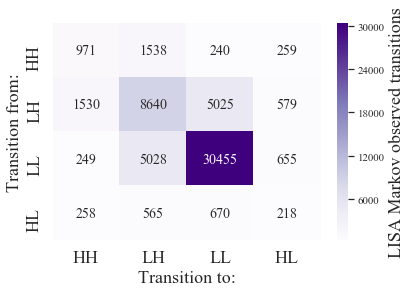

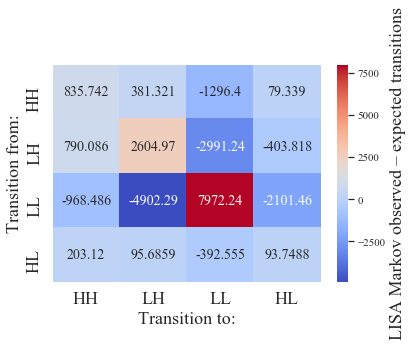

Count at 3 of 512.

Created grid in 0:00:01.429620.
LM calculated in 0:00:01.709412.
Count at 4 of 512.

Created grid in 0:00:01.882689.
LM calculated in 0:00:03.629697.
Count at 5 of 512.

Created grid in 0:00:01.958031.
LM calculated in 0:00:05.335370.
Count at 6 of 512.

CSR expected in pts_677.txt.
Count at 7 of 512.

Created grid in 0:00:07.201356.
LM calculated in 0:00:10.109480.
Count at 8 of 512.

CSR expected in pts_3293.txt.
Count at 9 of 512.

Created grid in 0:00:01.497941.
LM calculated in 0:00:04.745280.
Count at 10 of 512.

Created grid in 0:00:07.618535.
LM calculated in 0:00:10.123484.


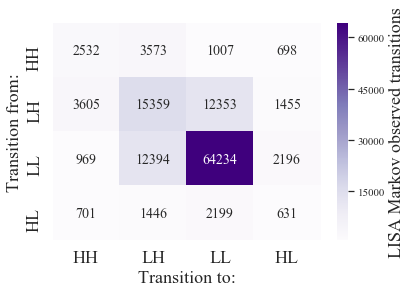

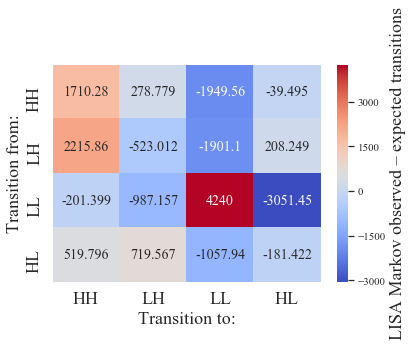

Count at 11 of 512.

CSR expected in pts_3668.txt.
Count at 12 of 512.

Created grid in 0:00:08.016961.
LM calculated in 0:00:09.752783.
Count at 13 of 512.

Created grid in 0:00:06.277983.
LM calculated in 0:00:10.937805.
Count at 14 of 512.

Created grid in 0:00:03.986271.
LM calculated in 0:00:06.505180.
Count at 15 of 512.

Created grid in 0:00:01.531614.
LM calculated in 0:00:01.846066.
Count at 16 of 512.

Created grid in 0:00:04.797297.
LM calculated in 0:00:07.523765.
Count at 17 of 512.

Created grid in 0:00:01.303394.
LM calculated in 0:00:03.491817.
Count at 18 of 512.

Created grid in 0:00:03.450653.
LM calculated in 0:00:04.859638.
Count at 19 of 512.

CSR expected in pts_3320.txt.
Count at 20 of 512.

Created grid in 0:00:01.407682.
LM calculated in 0:00:01.976718.
Count at 21 of 512.

CSR expected in pts_713.txt.
Count at 22 of 512.

Created grid in 0:00:00.996681.
LM calculated in 0:00:03.038036.
Count at 23 of 512.

Created grid in 0:00:02.250406.
LM calculated in 0:00

Created grid in 0:00:03.710626.
LM calculated in 0:00:05.488798.
Count at 112 of 512.

Created grid in 0:00:00.947078.
LM calculated in 0:00:02.191883.
Count at 113 of 512.

Created grid in 0:00:02.213205.
LM calculated in 0:00:04.036047.
Count at 114 of 512.

Created grid in 0:00:03.720434.
LM calculated in 0:00:05.948162.
Count at 115 of 512.

CSR expected in pts_4655.txt.
Count at 116 of 512.

Created grid in 0:00:03.454815.
LM calculated in 0:00:09.655902.
Count at 117 of 512.

Created grid in 0:00:08.100359.
LM calculated in 0:00:09.957220.
Count at 118 of 512.

Created grid in 0:00:01.469902.
LM calculated in 0:00:01.910567.
Count at 119 of 512.

Created grid in 0:00:03.252054.
LM calculated in 0:00:05.964044.
Count at 120 of 512.

Created grid in 0:00:01.970217.
LM calculated in 0:00:04.961630.
Count at 121 of 512.

Created grid in 0:00:02.311954.
LM calculated in 0:00:04.486612.
Count at 122 of 512.

Created grid in 0:00:05.594392.
LM calculated in 0:00:08.475819.


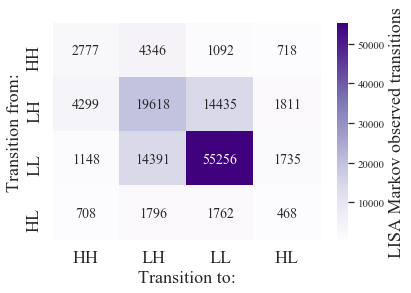

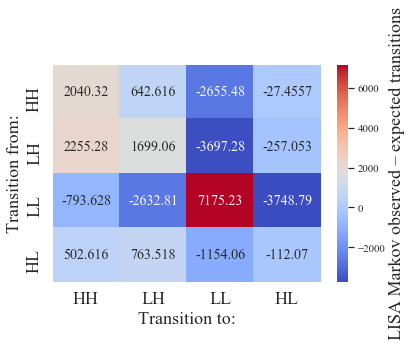

Count at 123 of 512.

Created grid in 0:00:02.143976.
LM calculated in 0:00:03.805260.
Count at 124 of 512.

CSR expected in pts_1665.txt.
Count at 125 of 512.

Created grid in 0:00:01.770290.
LM calculated in 0:00:04.067857.
Count at 126 of 512.

Created grid in 0:00:02.092886.
LM calculated in 0:00:04.139072.
Count at 127 of 512.

Created grid in 0:00:02.566937.
LM calculated in 0:00:04.056265.
Count at 128 of 512.

Created grid in 0:00:01.746946.
LM calculated in 0:00:03.695100.
Count at 129 of 512.

Created grid in 0:00:01.403658.
LM calculated in 0:00:03.151388.
Count at 130 of 512.

Created grid in 0:00:01.168225.
LM calculated in 0:00:01.892750.
Count at 131 of 512.

CSR expected in pts_695.txt.
Count at 132 of 512.

Created grid in 0:00:02.756384.
LM calculated in 0:00:03.786672.
Count at 133 of 512.

CSR expected in pts_3311.txt.
Count at 134 of 512.

Created grid in 0:00:02.377121.
LM calculated in 0:00:03.087824.
Count at 135 of 512.

Created grid in 0:00:02.889905.
LM calcu

Created grid in 0:00:03.013996.
LM calculated in 0:00:04.218535.
Count at 222 of 512.

Created grid in 0:00:02.543495.
LM calculated in 0:00:04.041885.
Count at 223 of 512.

CSR expected in pts_3990.txt.
Count at 224 of 512.

Created grid in 0:00:01.702039.
LM calculated in 0:00:02.961064.
Count at 225 of 512.

Created grid in 0:00:02.123594.
LM calculated in 0:00:02.149948.
Count at 226 of 512.

Created grid in 0:00:02.973416.
LM calculated in 0:00:10.665221.
Count at 227 of 512.

Created grid in 0:00:04.949507.
LM calculated in 0:00:10.865692.
Count at 228 of 512.

Created grid in 0:00:02.903265.
LM calculated in 0:00:04.100178.
Count at 229 of 512.

CSR expected in pts_1189.txt.
Count at 230 of 512.

Created grid in 0:00:01.911793.
LM calculated in 0:00:04.918048.
Count at 231 of 512.

Created grid in 0:00:04.842919.
LM calculated in 0:00:09.307382.
Count at 232 of 512.

Created grid in 0:00:02.841279.
LM calculated in 0:00:03.970852.
Count at 233 of 512.

Created grid in 0:00:01.81

Created grid in 0:00:02.204284.
LM calculated in 0:00:03.075807.
Count at 322 of 512.

Created grid in 0:00:03.091644.
LM calculated in 0:00:03.406577.
Count at 323 of 512.

Created grid in 0:00:04.037165.
LM calculated in 0:00:05.842812.
Count at 324 of 512.

Created grid in 0:00:08.165343.
LM calculated in 0:00:09.709705.
Count at 325 of 512.

Created grid in 0:00:02.137138.
LM calculated in 0:00:02.953492.
Count at 326 of 512.

Created grid in 0:00:01.968254.
LM calculated in 0:00:04.170775.
Count at 327 of 512.

Created grid in 0:00:02.936244.
LM calculated in 0:00:06.235400.
Count at 328 of 512.

Created grid in 0:00:01.074698.
LM calculated in 0:00:01.686408.
Count at 329 of 512.

Created grid in 0:00:03.830249.
LM calculated in 0:00:07.529024.
Count at 330 of 512.

Created grid in 0:00:01.774117.
LM calculated in 0:00:03.188604.
Count at 331 of 512.

Created grid in 0:00:01.316705.
LM calculated in 0:00:02.360511.
Count at 332 of 512.

Created grid in 0:00:02.628101.
LM calculat

In [5]:
static_frames, moving_frames = [], [] # Store cluster geometries
static_frames_t, moving_frames_t = [], [] # Store cluster times
lm_list,lm_moves_list = [], [] # Store lm objects and lm dfs
run_times = [] # Store runtimes
lm_times = []
grid_times = []
cluster_times = []
lm_record = 0

directory = '/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/pointFiles'
count = 0
length = len(os.listdir(directory))

for filename in os.listdir(directory)[166:]: # Iterate over each decomposition domain
    txt = pd.read_csv(directory+'/'+filename, skiprows=1, names=['lon','lat','time']) # read decomp
    txt = txt.sort_values(by='time')
    points = [[lat,lon] for lat,lon in zip(txt.lat, txt.lon)] # Save point patter to test global CSR
    txt['geometry'] = [shapely.geometry.Point(p) for p in points]
    txt = GeoDataFrame(txt)
    pp = PointPattern(points) # Create point pattern object
    domain_quadrat = qs.QStatistic(pp, shape= "rectangle", nx = 6, ny = 7) # Run quadrat analysis on point pattern object
    pv = float(str(domain_quadrat.chi2_pvalue)[0:4])
    if pv < 1.0: # If not CSR and if statistically significant
        start_time = datetime.now() # Time subdomain process
        
        # Create geo_df of points to rasterize
        grid_xmin,grid_ymin,grid_xmax,grid_ymax = txt.total_bounds # Get point bounds
        height = (grid_xmax-grid_xmin)/ 6 # Set grid resolution
        grid = glt.make_grid(txt,height, False).reset_index().rename(columns={'index':'Cell ID'})# Create unclipped grid    
        dfsjoin = gpd.sjoin(grid, txt) #Spatial join Points to polygons
        dfpivot = pd.pivot_table(dfsjoin,index='Cell ID',columns='time',aggfunc={'time':len})
        dfpivot.columns = dfpivot.columns.droplevel()
        grid = (grid.merge(dfpivot, how='left',on='Cell ID')).fillna(0)
        
        
        frames = [txt.loc[txt.time == t] for t in txt.time.unique()] 

        update = datetime.now()
        print(f'Created grid in {update - start_time}.')
        grid_times.append(update - start_time)
        
        
        W = ps.weights.Queen.from_dataframe(grid) # Calculate spatial Queen contiguity weights object from grid gdf 
        transitions = np.array(grid[grid.columns[2:]]) # Save transitions as matrix
        lm = ps.LISA_Markov(transitions,W) # Calculate LISA markov transitions from W and matrix
        lm_list.append(lm)
        lm_moves = lm_to_df(lm) # creat a LISA transition df of observed against expected
        lm_moves_list.append(lm_moves)
        
        lm_time = datetime.now()
        print(f'LM calculated in {lm_time - update}.')
        lm_times.append(lm_time - update)


#         frame_t, cluster_nps, cluster_hull = [],[],[]
        
#         for frame in frames:                
#             if len(frame)>4:
#                 points = [[lat,lon] for lat,lon in zip(frame.lat, frame.lon)]
#                 pp_t = PointPattern(points)
#                 stdd = std_distance(pp_t.points)
#                 q_h_t = qs.QStatistic(pp,shape= "rectangle",nx = 6, ny = 7)
#                 pv_t = float(str(q_h_t.chi2_pvalue)[0:4])
#                 if pv_t < 1.0: 
#                     clust = OPTICS(min_cluster_size=4).fit(points)
#                     labels = cluster_optics_dbscan(reachability=clust.reachability_,
#                                    core_distances=clust.core_distances_,
#                                        ordering=clust.ordering_, eps=stdd)
#                     frame['labels'] = labels
#                     for i in frame.labels.unique():
#                         if i > -1:
#                             if frame.labels.value_counts()[i] > 3:
#                                 geom = frame.loc[frame['labels']==i]
#                                 absortion_condition = PointPattern(zip(geom.lon.to_list(), geom.lat.to_list())).mean_nnd
#                                 cluster_hull.append\
#                                 (shapely.geometry.MultiPoint(geom.geometry.tolist()).convex_hull.buffer(distance=absortion_condition))
#                                 frame_t.append(frame.time.unique()[0])
        
        
        if lm_moves['Residuals']['LH-HH'] > lm_record:
            lm_record = lm_moves['Residuals']['LH-HH']
            LISA_markov_diagnostics(lm_moves)
            
            
#             moving_frames = moving_frames+cluster_hull
#             moving_frames_t = moving_frames_t+frame_t
#         else:
#             static_frames = static_frames+cluster_hull
#             static_frames_t = static_frames_t+frame_t
            
#         cluster_time = datetime.now()
#         print(f'Cluster extraction calculated in {cluster_time - lm_time}.')
#         cluster_times.append(cluster_time - lm_time)



#         end_time = datetime.now() # Save endtime
#         run_time = end_time - start_time # Find runtime to adjudge parallelization
#         run_times.append(run_time)
    else:
         print(f"CSR expected in {filename}.")
    count = count + 1
    print(f'Count at {count} of {length}.\n')

In [ ]:
run_times_seconds = [i.seconds for i in run_times]

In [ ]:
lm_times_seconds = [i.seconds for i in lm_times]
grid_times_seconds = [i.seconds for i in grid_times]
cluster_times_seconds = [i.seconds for i in cluster_times]

# NY Runtimes

In [11]:
run_times = [30, 45, 46, 194, 161, 6, 6, 119, 110, 7, 22, 140, 162, 20, 62, 15, 6, 5, 11, 2, 4, 12, 70, 6, 105, 5, 9, 13, 17, 4, 48, 120, 111, 9, 2, 8, 77, 4, 217, 4, 244, 157, 62, 4, 4, 5, 141, 20, 16, 66, 95, 189, 111, 93, 175, 4, 7, 12, 9, 4, 92, 199, 4, 7, 17, 14, 14, 9, 14, 148, 3, 151, 9, 13, 202, 61, 146, 32, 5, 4, 79, 43, 126, 100, 9, 204, 2, 5, 4, 25, 10, 123, 169, 4, 9, 25, 220, 135, 169, 155, 185, 7, 7, 10, 3, 101, 244, 5, 7, 79, 32, 7, 67, 2, 10, 104, 118, 109, 5, 10, 31, 10, 5, 176, 63, 215, 134, 143, 82, 51, 244, 2, 42, 52, 14, 84, 234, 26, 30, 16, 159, 9, 3, 5, 123, 9, 190, 77, 222, 190, 124, 72, 20, 9, 149, 4, 214, 204, 119, 90, 324, 34, 15, 5, 31, 47, 120, 315, 179, 20, 11, 8, 22, 138, 138, 65, 80, 111, 3, 185, 186, 223, 109, 4, 4, 133, 24, 46, 289, 296, 7, 87, 5, 193, 25, 88, 138, 5, 181, 11, 59, 5, 28, 7, 28, 6, 16, 164, 145, 44, 248, 116, 2, 14, 16, 4, 192, 159, 13, 3, 81, 4, 13, 4, 5, 74, 15, 6, 140, 4, 9, 6, 229, 120, 160, 82, 172, 128, 14, 76, 5, 119, 134, 86, 204, 7, 2, 4, 16, 37, 6, 61, 48, 62, 255, 7, 14, 15, 18, 6, 226, 3, 217, 53, 11, 7, 89, 5, 210, 20, 32, 146, 48, 6, 5, 137, 6, 21, 5, 95, 75, 87, 191, 13, 14, 63, 57, 9, 167, 4, 116, 7, 9, 14, 205, 106, 13, 2, 289, 15, 244, 159, 243, 3, 8, 209, 168, 10]

In [25]:
times_test = pd.read_pickle('NY_times.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'TK_times.pkl'

In [32]:
from matplotlib.pyplot import savefig

In [53]:
print(len(run_times))
run_times.remove(rto)
print(len(run_times))

476
475


In [54]:
print(len(ce_times))
ce_times.remove(ceo)
print(len(ce_times))

476
475


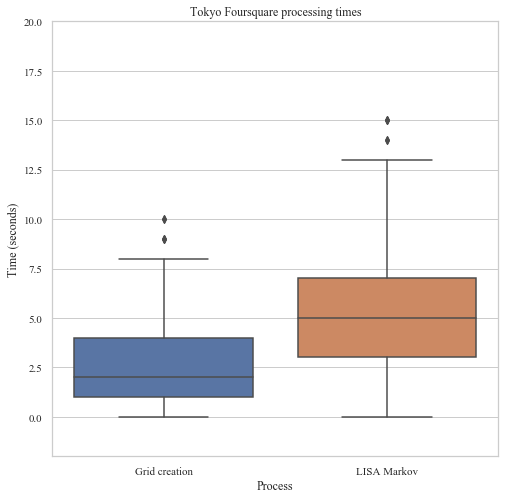

In [85]:
times = pd.DataFrame({'Grid creation':grid_times,'LISA Markov':lm_times,'Cluster extraction':ce_times,'Subdomain total':run_times}).reset_index().rename(columns={'index':'Subdomain'})
times = times.drop( times[ times['Cluster extraction'] > 20000 ].index)
times = times.drop( times[ times['Subdomain total'] > 20000 ].index)
times = times.melt('Subdomain', var_name='cols',  value_name='vals')
ax = sns.boxplot(x="cols", y="vals",data=times.loc[times.cols.isin(['Grid creation', 'LISA Markov'])])
ax.set_ylim(-2, 20);
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('Process');
ax.set_title('Tokyo Foursquare processing times');
plt.savefig('tk_gclm_times.png', dpi=100)

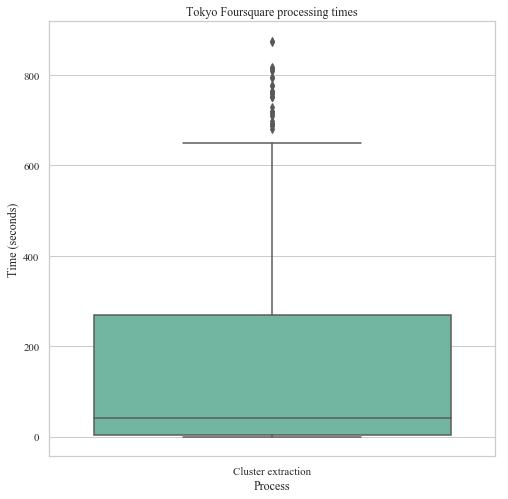

In [86]:
# times = times.drop(times[times['Cluster extraction'] < 20000].index)
# times = times.drop(times[times['Subdomain total'] < 20000].index)
ax = sns.boxplot(x="cols", y="vals",data=times.loc[times.cols.isin(['Cluster extraction'])],palette="Set2")
# ax.set_ylim(0,400);
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('Process');
ax.set_title('Tokyo Foursquare processing times');
plt.savefig('tk_ce_times.png', dpi=100)

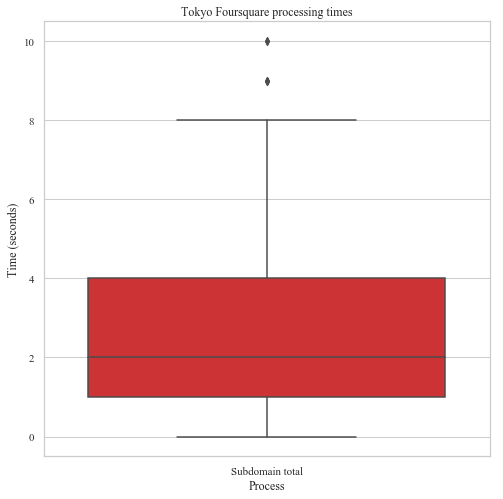

In [38]:
ax = sns.boxplot(x="cols", y="vals",data=times.loc[times.cols.isin(['Subdomain total'])],palette="Set1")
# ax.set_ylim(0,400);
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('Process');
ax.set_title('Tokyo Foursquare processing times');
plt.savefig('tk_total_times.png', dpi=100)

In [45]:
test = test.to_crs(epsg=4326)
test.to_file('/Users/GeorgePyne/Desktop/shptest/tk.shp')

In [ ]:
objects = ('Entire dataframe', 'Static cluster index', 'Moving cluster index')
y_pos = np.arange(len(objects))
performance = [sys.getsizeof(ny),sys.getsizeof(sc),sys.getsizeof(mc)]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Memory size')
# plt.title('Mem')

plt.show()

In [ ]:
print(sys.getsizeof(ny))
print(sys.getsizeof(sc))
print(sys.getsizeof(mc))

In [ ]:
pickle_dict = {}
for t, g in mc.items():
    geoms = g._geoms
    pickle_dict[t] = shapely.geometry.MultiPolygon(geoms).to_wkt()

In [185]:
def index_to_pickle(index, filename):
    pickle_dict = {}
    for t, g in index.items():
        geoms = g._geoms
        pickle_dict[t] = shapely.geometry.MultiPolygon(geoms).to_wkt()
    with open(f'{filename}.pickle', 'wb') as handle:
        pickle.dump(pickle_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# index_to_pickle(sc, 'sc')
# index_to_pickle(mc, 'mc')

In [316]:
def pickle_to_index(filename):
    import shapely.wkt as wkt
    pickle_dict = {}
    with open(f'{filename}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    for t, g in data.items():
        pickle_dict[t] = STRtree(wkt.loads(data[t]))
    
    return pickle_dict
    
    


# sc_test = pickle_to_index('sc')        
# mc_test = pickle_to_index('mc')

In [ ]:
sum(lm_moves_list)['Expected']['HH-HH']

In [136]:
def LISA_markov_diagnostics(lm_lmoves):
    
    
#     for lm in lm_list:
#         print("Chi2: %8.3f, p: %5.2f, dof: %d" % lm.chi_2)
    ax = sns.heatmap(np.matrix([lm_moves.Transitions[:4].values,\
    lm_moves.Transitions[4:8].values,\
    lm_moves.Transitions[8:12].values,\
    lm_moves.Transitions[12:].values]), cmap='Purples', 
                annot=True, annot_kws={'size':14}, cbar_kws={'label':"LISA Markov observed transitions"}, fmt='g')
    ax.figure.axes[-1].yaxis.label.set_size(18)
    ax.figure.axes[-1].yaxis.label.set_size(18)
    ax.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
    ax.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
    plt.ylabel("Transition from:", size=18)
    plt.xlabel("Transition to:", size=18,);
    plt.savefig('LM_tranisitions.png', dpi=100)
    plt.show();
    
    
    ax = sns.heatmap(np.matrix([lm_moves.Residuals[:4].values,\
    lm_moves.Residuals[4:8].values,\
    lm_moves.Residuals[8:12].values,\
    lm_moves.Residuals[12:].values]), cmap='coolwarm', 
                annot=True, annot_kws={'size':14}, cbar_kws={'label':"LISA Markov observed – expected transitions"}, fmt='g')
    ax.figure.axes[-1].yaxis.label.set_size(18)
    ax.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
    ax.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=18);
    plt.ylabel("Transition from:", size=18)
    plt.xlabel("Transition to:", size=18);
    plt.savefig('LM_residuals.png', dpi=100)
    plt.show();

        

In [ ]:
lm_total = sum(lm_moves_list)

In [ ]:
LISA_markov_diagnostics(lm_total)

In [ ]:
lm_total.to_pickle('NY_LM_total.pkl')

# Tokyo saves

In [63]:
# print(f'run_times = {[i.seconds for i in (run_times_81+run_times_82to191+run_times)]}')
run_times = [4, 11, 247, 531, 7, 33, 5, 40, 2, 359, 13, 8, 9, 236, 109, 72, 319, 62, 206, 23, 281, 2, 207, 364, 195, 89, 15, 1, 5, 393, 16, 34, 785, 20, 10, 664, 468, 202, 145, 248, 51, 547, 15, 11, 18, 126, 1, 105, 469, 395, 102, 540, 291, 13, 508, 367, 8, 8, 702, 240, 225, 411, 492, 818, 3, 98, 7, 27, 188, 8, 16, 278, 22, 3, 280, 387, 37, 161, 9, 11, 405, 28, 114, 5, 5, 350, 316, 444, 14, 88, 138, 5, 25, 129, 10, 6, 51, 353, 16, 26, 5, 247, 0, 161, 23, 15, 129, 783, 511, 4, 140, 6, 66, 312, 12, 712, 11, 598, 193, 11, 237, 22, 55, 70, 3, 15, 13, 817, 75, 129, 237, 7, 11, 3, 103, 738, 7, 196, 13, 78, 285, 2, 837, 19, 11, 443, 98, 12, 6, 9, 66, 9, 715, 7, 14, 22, 32, 4, 47, 175, 5, 13, 15, 163, 6, 712, 752, 391, 338, 6, 830, 10, 57, 11, 13, 223, 50, 8, 3, 26, 24, 10, 13, 12, 16, 8, 5, 106, 96, 21875, 4, 8, 2, 19, 21, 9, 13, 10, 19, 9, 5, 110, 101, 311, 5, 4, 776, 753, 413, 516, 645, 24, 192, 2, 18, 53, 2, 24, 435, 8, 231, 261, 1, 13, 15, 328, 205, 792, 325, 7, 14, 106, 158, 50, 4, 23, 564, 116, 545, 226, 4, 571, 227, 14, 585, 312, 4, 11, 9, 452, 776, 4, 8, 45, 185, 119, 32, 5, 335, 231, 9, 8, 2, 259, 52, 105, 660, 303, 328, 521, 7, 210, 327, 115, 167, 8, 15, 11, 18, 772, 118, 8, 104, 201, 45, 6, 3, 6, 12, 96, 9, 771, 70, 893, 10, 309, 413, 565, 5, 5, 256, 50, 9, 57, 834, 211, 8, 43, 80, 110, 22, 33, 29, 3, 126, 86, 8, 79, 7, 304, 768, 481, 714, 464, 14, 41, 17, 326, 9, 15, 270, 232, 180, 3, 76, 14, 647, 12, 6, 135, 3, 13, 8, 246, 12, 9, 122, 62, 18, 368, 3, 730, 702, 9, 278, 201, 376, 1, 9, 4, 8, 23, 193, 10, 447, 78, 233, 19, 168, 10, 10, 6, 28, 31, 22, 23, 449, 163, 41, 596, 206, 488, 297, 8, 728, 9, 21, 540, 784, 9, 318, 54, 118, 6, 103, 4, 8, 399, 22, 7, 11, 8, 128, 360, 5, 436, 447, 288, 660, 305, 301, 40, 21, 424, 3, 66, 201, 901, 296, 0, 394, 11, 535, 146, 94, 16, 13, 4, 2, 12, 0, 6, 12, 381, 233, 18, 279, 636, 5, 282, 253, 832, 13, 2, 73, 395, 457, 275, 13, 128, 7, 12, 593, 6, 27, 10, 30, 350, 17, 8, 131, 5, 116, 5, 3, 31, 8, 133, 429, 259, 797, 598, 3, 362, 833, 29]

In [64]:
# print(f'lm_times = {[i.seconds for i in (lm_times_81+lm_times_82to191+lm_times)]}')
lm_times = [1, 3, 7, 7, 4, 3, 2, 5, 1, 8, 3, 4, 6, 7, 12, 8, 12, 9, 6, 4, 13, 1, 9, 9, 6, 10, 4, 1, 2, 8, 4, 4, 13, 7, 2, 9, 8, 4, 3, 7, 4, 8, 4, 4, 5, 9, 1, 6, 7, 6, 9, 9, 6, 4, 9, 11, 4, 3, 13, 8, 4, 6, 10, 15, 1, 3, 3, 13, 13, 4, 5, 9, 8, 2, 7, 7, 6, 5, 5, 4, 10, 3, 3, 2, 2, 5, 7, 7, 5, 7, 13, 2, 5, 5, 3, 3, 6, 8, 8, 11, 3, 10, 0, 13, 6, 8, 6, 14, 9, 2, 11, 3, 10, 13, 5, 12, 3, 13, 5, 4, 4, 5, 4, 4, 2, 4, 3, 13, 8, 5, 10, 4, 5, 2, 11, 11, 1, 8, 5, 3, 12, 1, 13, 5, 6, 9, 11, 4, 2, 3, 5, 5, 13, 5, 4, 6, 12, 2, 7, 6, 2, 5, 6, 6, 3, 11, 14, 12, 10, 3, 13, 6, 8, 3, 4, 6, 5, 2, 2, 9, 7, 2, 3, 3, 5, 3, 1, 6, 3, 8, 2, 2, 1, 6, 6, 2, 4, 2, 6, 3, 1, 7, 3, 8, 2, 2, 9, 22, 6, 13, 12, 9, 7, 1, 5, 5, 1, 5, 9, 3, 4, 5, 1, 3, 4, 9, 4, 10, 12, 3, 3, 11, 6, 7, 1, 9, 11, 3, 7, 7, 3, 6, 7, 5, 8, 5, 1, 4, 3, 8, 15, 2, 3, 5, 13, 3, 4, 1, 6, 6, 5, 2, 1, 5, 5, 3, 9, 10, 12, 8, 3, 7, 9, 7, 13, 3, 8, 6, 5, 12, 4, 3, 3, 3, 4, 2, 1, 3, 2, 6, 4, 8, 6, 11, 4, 4, 13, 7, 2, 1, 5, 6, 5, 6, 10, 5, 2, 3, 6, 3, 5, 3, 2, 2, 4, 2, 3, 6, 4, 7, 10, 7, 9, 6, 3, 5, 3, 10, 2, 3, 5, 5, 4, 1, 5, 3, 9, 5, 3, 10, 2, 3, 3, 7, 5, 2, 8, 5, 3, 11, 1, 10, 8, 4, 6, 5, 7, 1, 5, 2, 2, 6, 4, 2, 5, 6, 5, 6, 3, 4, 3, 2, 8, 9, 5, 8, 13, 4, 3, 7, 4, 6, 4, 3, 8, 3, 5, 7, 11, 2, 4, 6, 7, 3, 6, 2, 4, 7, 4, 4, 4, 2, 5, 9, 2, 10, 7, 4, 9, 5, 6, 4, 3, 8, 1, 3, 7, 15, 6, 0, 5, 2, 6, 6, 5, 6, 4, 3, 1, 5, 0, 2, 3, 13, 7, 4, 3, 8, 2, 4, 4, 10, 4, 1, 6, 7, 9, 3, 3, 6, 2, 6, 7, 3, 3, 3, 4, 8, 3, 4, 7, 2, 8, 2, 2, 7, 2, 3, 6, 4, 12, 7, 1, 5, 10, 6]

In [65]:
# print(f'ce_times = {[i.seconds for i in (cluster_times_81+cluster_times_82to191+cluster_times)]}')
ce_times = [2, 5, 234, 519, 1, 27, 1, 32, 0, 345, 7, 2, 1, 223, 92, 60, 300, 48, 196, 16, 263, 0, 193, 350, 186, 74, 9, 0, 2, 379, 9, 27, 765, 9, 5, 649, 455, 194, 139, 237, 43, 533, 8, 3, 9, 112, 0, 95, 456, 384, 88, 523, 279, 6, 492, 349, 1, 3, 681, 226, 217, 400, 475, 794, 0, 92, 2, 9, 169, 2, 7, 262, 10, 0, 267, 376, 27, 152, 2, 3, 388, 21, 109, 1, 2, 342, 303, 432, 6, 78, 119, 1, 16, 122, 5, 0, 42, 340, 4, 11, 0, 231, 0, 141, 13, 4, 119, 760, 495, 0, 122, 0, 51, 293, 4, 691, 6, 579, 184, 5, 230, 14, 48, 64, 0, 8, 7, 796, 63, 121, 223, 1, 3, 0, 85, 718, 4, 182, 6, 73, 268, 0, 814, 10, 3, 428, 82, 6, 2, 3, 59, 1, 692, 1, 6, 13, 16, 0, 36, 165, 2, 4, 6, 154, 1, 692, 730, 370, 323, 1, 808, 2, 44, 5, 7, 213, 42, 3, 0, 12, 13, 6, 7, 6, 8, 3, 2, 96, 91, 21863, 1, 2, 0, 10, 12, 6, 6, 6, 10, 3, 2, 99, 96, 297, 1, 0, 760, 720, 403, 495, 625, 10, 179, 0, 11, 46, 0, 16, 420, 2, 223, 252, 0, 8, 8, 314, 198, 775, 307, 2, 8, 90, 148, 40, 1, 11, 548, 111, 532, 215, 0, 559, 216, 6, 572, 304, 1, 4, 3, 438, 751, 1, 2, 37, 167, 113, 25, 2, 323, 221, 1, 4, 0, 250, 45, 98, 646, 284, 308, 504, 2, 198, 312, 103, 148, 3, 3, 2, 10, 751, 112, 3, 99, 196, 39, 3, 1, 0, 8, 86, 3, 758, 59, 874, 4, 302, 394, 553, 1, 2, 247, 40, 2, 48, 817, 202, 5, 38, 71, 105, 13, 28, 24, 0, 120, 81, 2, 70, 1, 293, 752, 469, 699, 453, 8, 32, 11, 309, 6, 9, 261, 223, 173, 0, 69, 9, 631, 4, 1, 120, 0, 7, 4, 234, 3, 5, 109, 54, 12, 350, 0, 710, 687, 3, 268, 192, 364, 0, 2, 0, 3, 15, 187, 5, 437, 69, 224, 11, 163, 3, 4, 1, 16, 18, 15, 12, 426, 156, 36, 583, 199, 477, 289, 4, 714, 3, 13, 528, 765, 4, 310, 43, 107, 1, 92, 1, 2, 387, 14, 1, 4, 3, 119, 347, 1, 421, 435, 281, 645, 296, 289, 33, 15, 410, 1, 61, 190, 875, 285, 0, 385, 7, 524, 136, 86, 7, 5, 0, 0, 4, 0, 1, 6, 361, 222, 12, 273, 623, 2, 275, 246, 816, 6, 0, 63, 382, 442, 269, 7, 117, 3, 3, 580, 1, 22, 4, 22, 337, 9, 1, 120, 0, 103, 1, 0, 21, 3, 127, 420, 252, 779, 585, 0, 353, 815, 20]

In [66]:
# print(f'run_times = {[i.seconds for i in (grid_times_81+grid_times_82to191+grid_times)]}')
grid_times = [1, 2, 4, 4, 1, 2, 1, 2, 0, 5, 2, 1, 2, 6, 4, 3, 6, 3, 3, 2, 4, 0, 5, 4, 2, 3, 2, 0, 1, 4, 2, 2, 6, 3, 1, 5, 4, 2, 2, 3, 2, 5, 2, 3, 3, 4, 0, 3, 5, 4, 4, 7, 4, 2, 5, 7, 1, 2, 7, 4, 2, 4, 6, 9, 1, 2, 1, 4, 5, 2, 4, 6, 2, 1, 5, 3, 3, 3, 2, 3, 5, 2, 2, 1, 1, 2, 5, 4, 2, 2, 5, 1, 2, 2, 2, 1, 2, 4, 3, 3, 1, 5, 0, 5, 3, 2, 3, 7, 6, 1, 5, 1, 5, 5, 2, 8, 1, 6, 3, 1, 3, 2, 1, 2, 1, 1, 2, 6, 2, 2, 3, 1, 2, 1, 5, 8, 1, 5, 2, 2, 4, 1, 8, 3, 1, 5, 5, 1, 1, 2, 2, 2, 8, 1, 2, 2, 2, 1, 3, 3, 1, 3, 1, 2, 1, 8, 7, 7, 4, 1, 8, 2, 4, 1, 1, 3, 1, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 3, 2, 4, 0, 2, 1, 2, 2, 1, 3, 1, 2, 1, 1, 3, 2, 4, 1, 1, 5, 10, 3, 7, 7, 4, 5, 0, 2, 2, 0, 2, 5, 1, 2, 3, 0, 1, 2, 5, 3, 6, 6, 1, 2, 4, 3, 2, 1, 2, 4, 1, 5, 3, 1, 4, 4, 2, 4, 2, 1, 2, 1, 5, 9, 1, 1, 2, 5, 2, 2, 1, 4, 3, 2, 1, 0, 3, 2, 2, 5, 7, 7, 8, 1, 4, 5, 4, 5, 2, 3, 2, 2, 8, 2, 1, 1, 2, 1, 1, 0, 1, 1, 3, 1, 4, 3, 7, 2, 2, 5, 4, 1, 1, 3, 3, 2, 3, 6, 3, 1, 1, 3, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 3, 5, 4, 5, 4, 1, 3, 1, 6, 1, 2, 3, 3, 2, 0, 2, 1, 5, 2, 1, 4, 1, 2, 1, 4, 2, 1, 4, 2, 2, 5, 1, 8, 5, 1, 3, 3, 4, 0, 1, 1, 1, 2, 2, 1, 3, 2, 3, 2, 2, 2, 2, 1, 2, 3, 2, 2, 9, 2, 1, 4, 2, 3, 2, 1, 5, 2, 2, 4, 7, 2, 3, 3, 3, 1, 3, 1, 1, 4, 2, 1, 1, 2, 3, 4, 1, 5, 4, 2, 4, 2, 4, 2, 2, 5, 1, 1, 4, 10, 4, 0, 3, 1, 4, 3, 2, 2, 3, 1, 0, 2, 0, 1, 2, 6, 3, 2, 2, 4, 1, 2, 2, 5, 2, 0, 3, 4, 5, 2, 2, 3, 1, 2, 4, 1, 1, 2, 2, 5, 3, 2, 3, 1, 4, 1, 0, 2, 2, 2, 3, 2, 6, 5, 1, 3, 7, 2]

In [163]:
run_times_82to191 = run_times[:-1]
lm_times_82to191 = lm_times[:-2]
grid_times_82to191 = grid_times[:-2]
cluster_times_82to191 = cluster_times[:-1]

In [152]:
print(len(run_times[:-2]))
print(len(lm_times[:-3]))
print(len(grid_times[:-3]))
print(len(cluster_times[:-2]))

109
109
109
109


In [136]:
run_times_81 = run_times[:-1]
lm_times_81 = lm_times[:-2]
grid_times_81 = grid_times[:-2]
cluster_times_81 = cluster_times[:-1]

In [ ]:
static_frames_81 = static_frames
moving_frames_81 = moving_frames
static_frames_t_81 = static_frames_t
moving_frames_t_81 = moving_frames_t



In [181]:
tk_sc = create_index((static_frames_t_81+static_frames_t_82to191+static_frames_t),(static_frames_81+static_frames_82to191+static_frames))

In [183]:
tk_mc = create_index((moving_frames_t_81+moving_frames_t_82to191+moving_frames_t),(moving_frames_81+moving_frames_82to191+moving_frames))

In [186]:
index_to_pickle(tk_sc, 'tk_sc')
index_to_pickle(tk_mc, 'tk_mc')

In [191]:
pickle_to_index('tk_mc')

{9110.0: <shapely.strtree.STRtree at 0x1a2bdfbd68>,
 9131.0: <shapely.strtree.STRtree at 0x1a4749cfd0>,
 10215.0: <shapely.strtree.STRtree at 0x1a474a48d0>,
 3209.0: <shapely.strtree.STRtree at 0x1a474a4f98>,
 3210.0: <shapely.strtree.STRtree at 0x1a474a9f60>,
 3214.0: <shapely.strtree.STRtree at 0x1a474aefd0>,
 3216.0: <shapely.strtree.STRtree at 0x1a474b4eb8>,
 3217.0: <shapely.strtree.STRtree at 0x1a474baf98>,
 3227.0: <shapely.strtree.STRtree at 0x1a474c0a90>,
 3229.0: <shapely.strtree.STRtree at 0x1a474cc128>,
 3233.0: <shapely.strtree.STRtree at 0x1a474ccdd8>,
 3234.0: <shapely.strtree.STRtree at 0x1a474d1ef0>,
 3240.0: <shapely.strtree.STRtree at 0x1a47642da0>,
 3242.0: <shapely.strtree.STRtree at 0x1a476479e8>,
 3244.0: <shapely.strtree.STRtree at 0x1a4764d9b0>,
 3246.0: <shapely.strtree.STRtree at 0x1a47653ac8>,
 3249.0: <shapely.strtree.STRtree at 0x1a47659a90>,
 3252.0: <shapely.strtree.STRtree at 0x1a4765fc50>,
 3253.0: <shapely.strtree.STRtree at 0x1a47664d68>,
 3256.0: <s

In [164]:
static_frames_82to191 = static_frames
moving_frames_82to191 = moving_frames
static_frames_t_82to191 = static_frames_t
moving_frames_t_82to191 = moving_frames_t

In [202]:
pickle_to_index('tk_sc')

{7479.0: <shapely.strtree.STRtree at 0x1a27cb7ef0>,
 7493.0: <shapely.strtree.STRtree at 0x1a405055f8>,
 7523.0: <shapely.strtree.STRtree at 0x1a40505d68>,
 8226.0: <shapely.strtree.STRtree at 0x1a4050b470>,
 8232.0: <shapely.strtree.STRtree at 0x1a4050bb38>,
 8235.0: <shapely.strtree.STRtree at 0x1a40510198>,
 8241.0: <shapely.strtree.STRtree at 0x1a405106d8>,
 8249.0: <shapely.strtree.STRtree at 0x1a40510da0>,
 8256.0: <shapely.strtree.STRtree at 0x1a40516400>,
 8356.0: <shapely.strtree.STRtree at 0x1a40516ac8>,
 8364.0: <shapely.strtree.STRtree at 0x1a4051b470>,
 9110.0: <shapely.strtree.STRtree at 0x1a4051bd30>,
 9113.0: <shapely.strtree.STRtree at 0x1a3bfe7438>,
 9131.0: <shapely.strtree.STRtree at 0x1a3bfe7a20>,
 9150.0: <shapely.strtree.STRtree at 0x1a3bfec5f8>,
 9180.0: <shapely.strtree.STRtree at 0x1a3bfecdd8>,
 9797.0: <shapely.strtree.STRtree at 0x1a3bff3400>,
 9800.0: <shapely.strtree.STRtree at 0x1a3bff39e8>,
 9803.0: <shapely.strtree.STRtree at 0x1a3bff3f60>,
 9805.0: <sh

In [4]:
lm_moves_list[166]

NameError: name 'lm_moves_list' is not defined

In [8]:
(sum(lm_moves_list)+pd.read_pickle('TK_LM_166.pkl')).to_pickle('TK_LM.pkl')

In [12]:
tk_mc_index = pickle_to_index('tk_mc')
ny_mc_index = pickle_to_index('mc')

In [13]:
ny_mc_index

{117.0: <shapely.strtree.STRtree at 0x1a1f1451d0>,
 118.0: <shapely.strtree.STRtree at 0x1a26f9d7b8>,
 142.0: <shapely.strtree.STRtree at 0x1a26f9d588>,
 147.0: <shapely.strtree.STRtree at 0x1a26f9d2b0>,
 151.0: <shapely.strtree.STRtree at 0x1a26d56d68>,
 163.0: <shapely.strtree.STRtree at 0x1a26d56a20>,
 174.0: <shapely.strtree.STRtree at 0x1a26d562b0>,
 175.0: <shapely.strtree.STRtree at 0x1a26d56668>,
 177.0: <shapely.strtree.STRtree at 0x1a2092c8d0>,
 552.0: <shapely.strtree.STRtree at 0x1a23ca4b00>,
 555.0: <shapely.strtree.STRtree at 0x1a23ca4f60>,
 564.0: <shapely.strtree.STRtree at 0x1a23ca4320>,
 572.0: <shapely.strtree.STRtree at 0x1a27999c18>,
 587.0: <shapely.strtree.STRtree at 0x1a27999eb8>,
 627.0: <shapely.strtree.STRtree at 0x1a23ca53c8>,
 678.0: <shapely.strtree.STRtree at 0x1a23ca5710>,
 701.0: <shapely.strtree.STRtree at 0x1a23ca5e10>,
 742.0: <shapely.strtree.STRtree at 0x1a26f9c240>,
 772.0: <shapely.strtree.STRtree at 0x1a26f9c7f0>,
 864.0: <shapely.strtree.STRtre

## Save Figures for TK & NY

In [114]:
tk_times.to_pickle('TK_times.pkl')

In [88]:
ny_times, tk_times = pd.read_pickle('NY_times.pkl'),pd.read_pickle('TK_times.pkl')

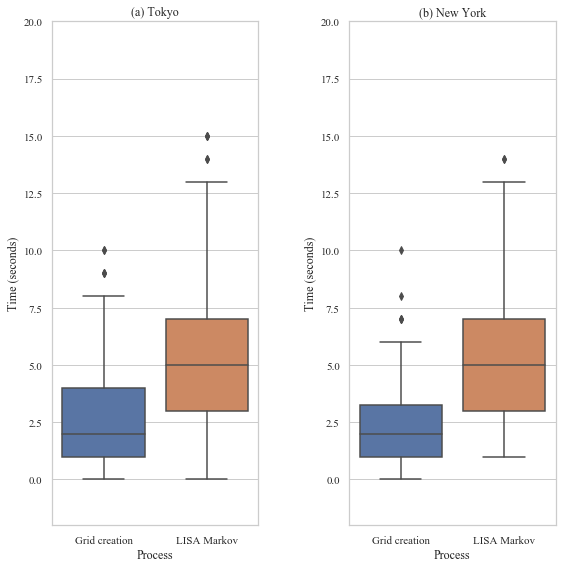

In [305]:
f, axes = plt.subplots(1, 2)

tk_times = pd.DataFrame({'Grid creation':grid_times,'LISA Markov':lm_times,'Cluster extraction':ce_times,'Subdomain total':run_times}).reset_index().rename(columns={'index':'Subdomain'})
tk_times = tk_times.drop( tk_times[ tk_times['Cluster extraction'] > 20000 ].index)
tk_times = tk_times.drop( tk_times[ tk_times['Subdomain total'] > 20000 ].index)
tk_times = tk_times.melt('Subdomain', var_name='cols',  value_name='vals')
ax1 = sns.boxplot(x="cols", y="vals",data=tk_times.loc[tk_times.cols.isin(['Grid creation', 'LISA Markov'])],ax=axes[0])
ax1.set_ylim(-2, 20);
ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('Process');
ax1.set_title('(a) Tokyo');


ax2 = sns.boxplot(x="cols", y="vals",data=ny_times.loc[ny_times.cols.isin(['Grid creation', 'LISA Markov'])],ax=axes[1])
ax2.set_ylim(-2, 20);
ax2.set_ylabel('Time (seconds)')
ax2.set_xlabel('Process');
ax2.set_title('(b) New York');
plt.tight_layout(w_pad=4)
plt.savefig('gclm.png',dpi=75)

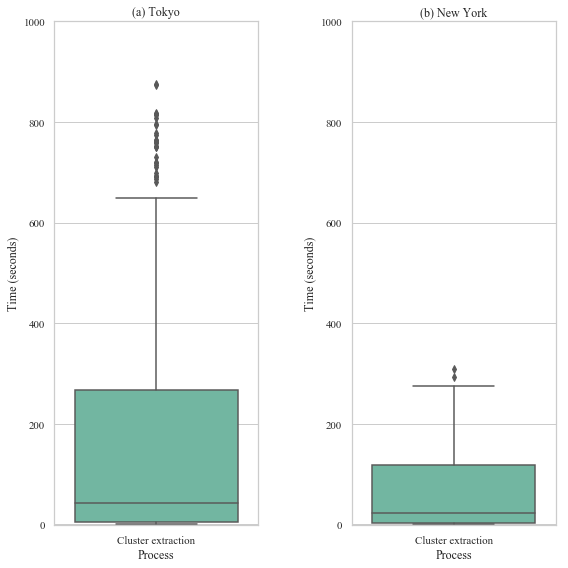

In [306]:
f, axes = plt.subplots(1, 2)

tk_times = pd.DataFrame({'Grid creation':grid_times,'LISA Markov':lm_times,'Cluster extraction':ce_times,'Subdomain total':run_times}).reset_index().rename(columns={'index':'Subdomain'})
tk_times = tk_times.drop( tk_times[ tk_times['Cluster extraction'] > 20000 ].index)
tk_times = tk_times.drop( tk_times[ tk_times['Subdomain total'] > 20000 ].index)
tk_times = tk_times.melt('Subdomain', var_name='cols',  value_name='vals')
ax1 = sns.boxplot(x="cols", y="vals",data=tk_times.loc[tk_times.cols.isin(['Cluster extraction'])],ax=axes[0],palette="Set2")
ax1.set_ylim(-2, 1000);
ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('Process');
ax1.set_title('(a) Tokyo');


ax2 = sns.boxplot(x="cols", y="vals",data=ny_times.loc[ny_times.cols.isin(['Cluster extraction'])],ax=axes[1],palette="Set2")
ax2.set_ylim(-2, 1000);
ax2.set_ylabel('Time (seconds)')
ax2.set_xlabel('Process');
ax2.set_title('(b) New York');
plt.tight_layout(w_pad=4)
plt.savefig('ce.png',dpi=75)

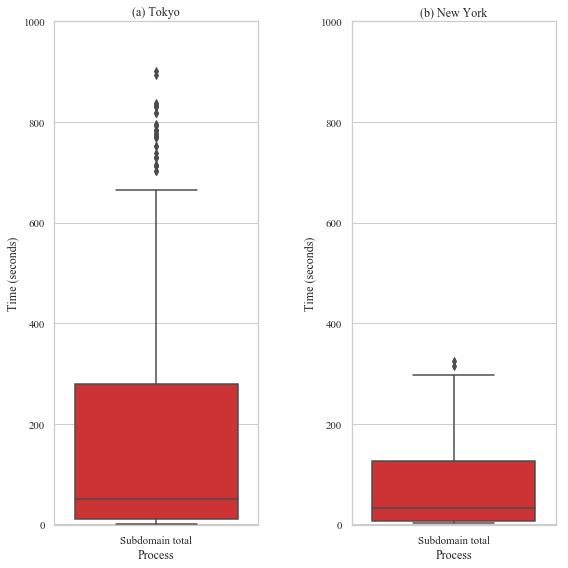

In [307]:
f, axes = plt.subplots(1, 2)

tk_times = pd.DataFrame({'Grid creation':grid_times,'LISA Markov':lm_times,'Cluster extraction':ce_times,'Subdomain total':run_times}).reset_index().rename(columns={'index':'Subdomain'})
tk_times = tk_times.drop( tk_times[ tk_times['Cluster extraction'] > 20000 ].index)
tk_times = tk_times.drop( tk_times[ tk_times['Subdomain total'] > 20000 ].index)
tk_times = tk_times.melt('Subdomain', var_name='cols',  value_name='vals')
ax1 = sns.boxplot(x="cols", y="vals",data=tk_times.loc[tk_times.cols.isin(['Subdomain total'])],ax=axes[0],palette="Set1")
ax1.set_ylim(-2, 1000);
ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('Process');
ax1.set_title('(a) Tokyo');


ax2 = sns.boxplot(x="cols", y="vals",data=ny_times.loc[ny_times.cols.isin(['Subdomain total'])],ax=axes[1],palette="Set1")
ax2.set_ylim(-2, 1000);
ax2.set_ylabel('Time (seconds)')
ax2.set_xlabel('Process');
ax2.set_title('(b) New York');
plt.tight_layout(w_pad=4)
plt.savefig('rt.png',dpi=75)

In [128]:
tk_lm_moves = pd.read_pickle('TK_LM.pkl')
ny_lm_moves = pd.read_pickle('NY_LM_total.pkl')

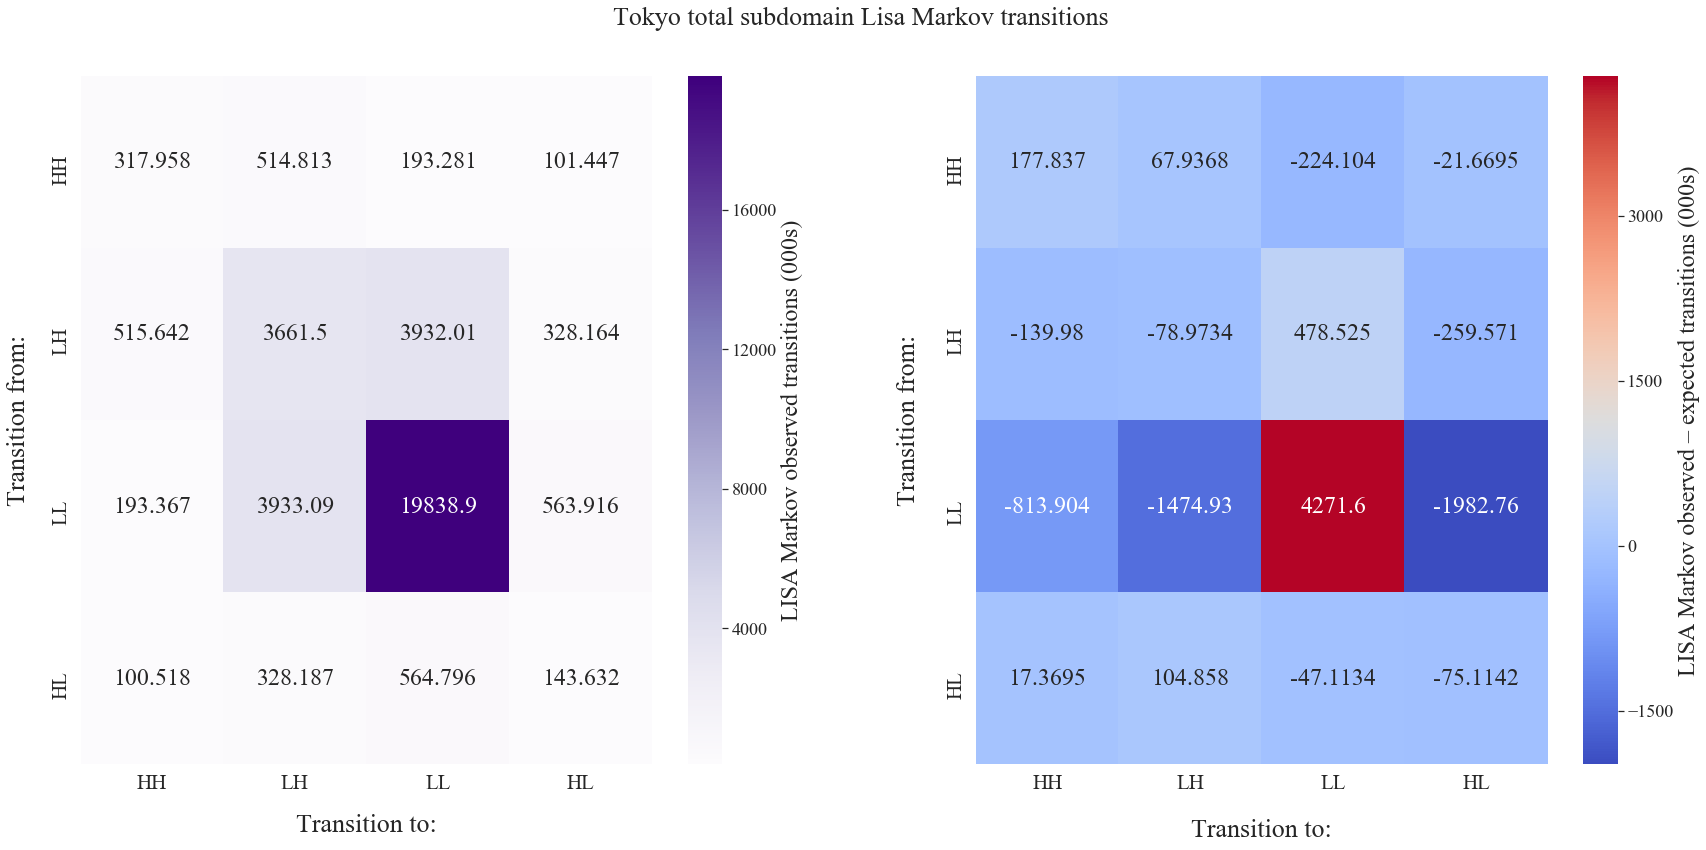

In [293]:
lm_moves = tk_lm_moves
lm_moves = lm_moves/1000

f, axes = plt.subplots(1, 2, figsize=(24.0, 12.0))
ax1 = sns.heatmap(np.matrix([lm_moves.Transitions[:4].values,\
lm_moves.Transitions[4:8].values,\
lm_moves.Transitions[8:12].values,\
lm_moves.Transitions[12:].values]), cmap='Purples', 
                  annot=True, annot_kws={'size':24}, cbar_kws={'label':"LISA Markov observed transitions (000s)"}, fmt='g', ax=axes[0])
ax1.figure.axes[-1].yaxis.label.set_size(24)
ax1.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax1.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax1.set_ylabel("Transition from:", size=26, labelpad=20)
ax1.set_xlabel("Transition to:", size=26, labelpad=20);
cbar1 = ax1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=18) 



ax2 = sns.heatmap(np.matrix([lm_moves.Residuals[:4].values,\
lm_moves.Residuals[4:8].values,\
lm_moves.Residuals[8:12].values,\
lm_moves.Residuals[12:].values]), cmap='coolwarm', 
            annot=True, annot_kws={'size':24}, cbar_kws={'label':"LISA Markov observed – expected transitions (000s)"}, fmt='g', ax=axes[1])
ax2.figure.axes[-1].yaxis.label.set_size(24)
ax2.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax2.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax2.set_ylabel("Transition from:", size=26, labelpad=25)
ax2.set_xlabel("Transition to:", size=26, labelpad=25);
cbar2 = ax2.collections[0].colorbar
cbar2.ax.tick_params(labelsize=18) 
plt.tight_layout(w_pad=8)
plt.subplots_adjust(top=0.90)
f.suptitle('Tokyo total subdomain Lisa Markov transitions', size=26, verticalalignment='top');
plt.savefig('tk_lm.png', dpi=100)


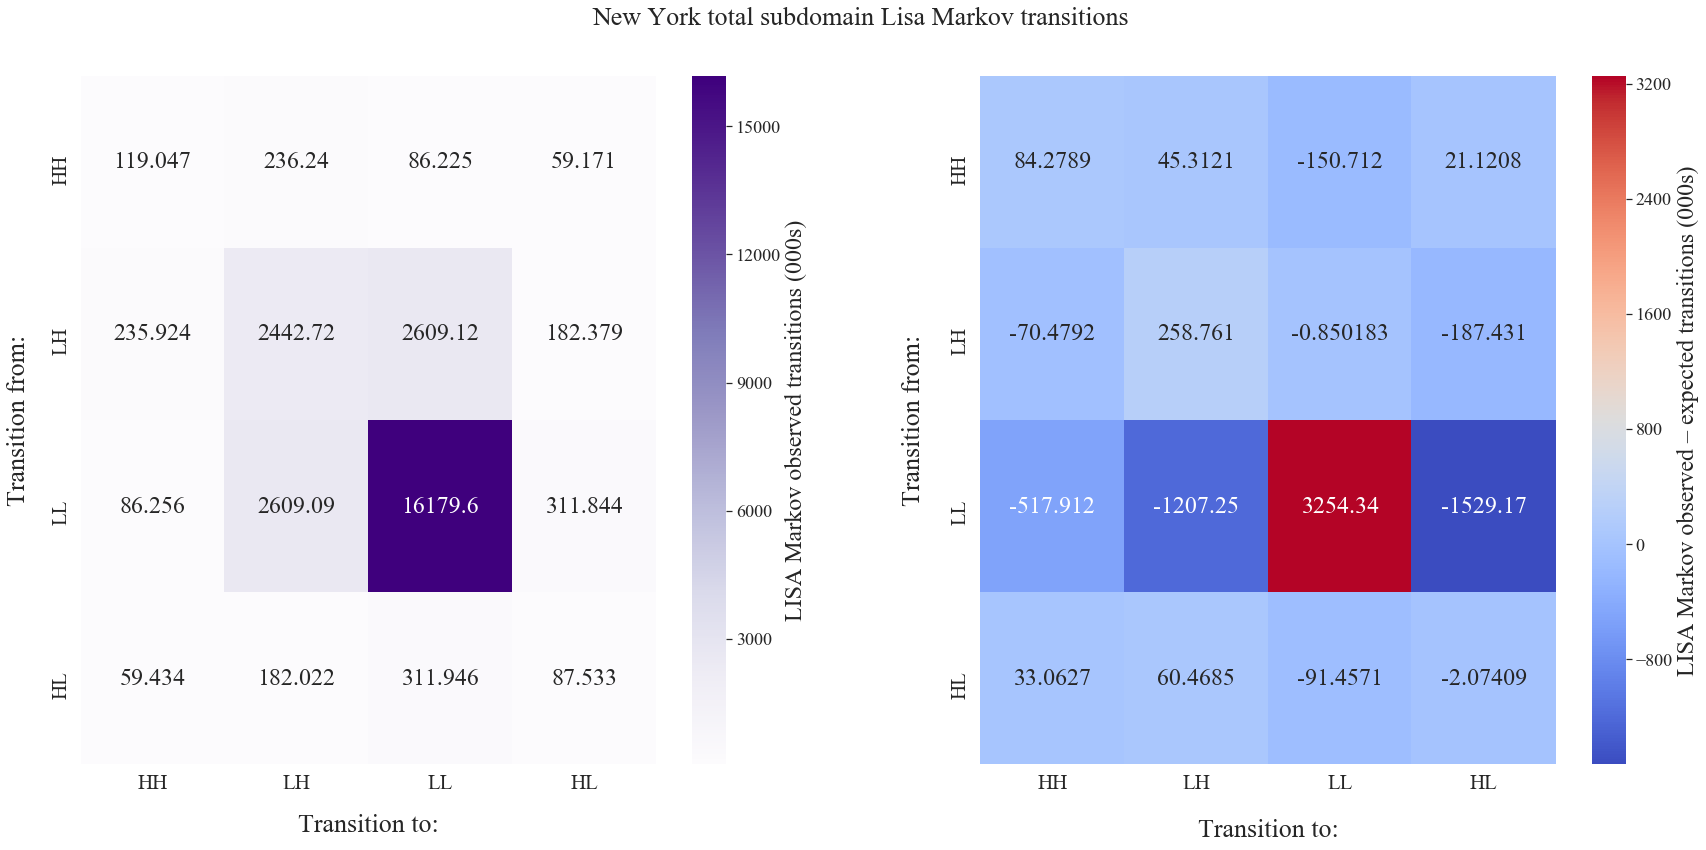

In [294]:
lm_moves = ny_lm_moves
lm_moves = lm_moves/1000

f, axes = plt.subplots(1, 2, figsize=(24.0, 12.0))
ax1 = sns.heatmap(np.matrix([lm_moves.Transitions[:4].values,\
lm_moves.Transitions[4:8].values,\
lm_moves.Transitions[8:12].values,\
lm_moves.Transitions[12:].values]), cmap='Purples', 
                  annot=True, annot_kws={'size':24}, cbar_kws={'label':"LISA Markov observed transitions (000s)"}, fmt='g', ax=axes[0])
ax1.figure.axes[-1].yaxis.label.set_size(24)
ax1.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax1.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax1.set_ylabel("Transition from:", size=26, labelpad=20)
ax1.set_xlabel("Transition to:", size=26, labelpad=20);
cbar1 = ax1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=18) 


ax2 = sns.heatmap(np.matrix([lm_moves.Residuals[:4].values,\
lm_moves.Residuals[4:8].values,\
lm_moves.Residuals[8:12].values,\
lm_moves.Residuals[12:].values]), cmap='coolwarm', 
            annot=True, annot_kws={'size':24}, cbar_kws={'label':"LISA Markov observed – expected transitions (000s)"}, fmt='g', ax=axes[1])
ax2.figure.axes[-1].yaxis.label.set_size(24)
ax2.set_yticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax2.set_xticklabels(labels=['HH', 'LH', 'LL', 'HL'], size=21);
ax2.set_ylabel("Transition from:", size=26, labelpad=25)
ax2.set_xlabel("Transition to:", size=26, labelpad=25);
cbar2 = ax2.collections[0].colorbar
cbar2.ax.tick_params(labelsize=18)
plt.tight_layout(w_pad=8)
plt.subplots_adjust(top=0.90)
f.suptitle('New York total subdomain Lisa Markov transitions', size=26, verticalalignment='top');
plt.savefig('ny_lm.png', dpi=100)



In [332]:
extract_moving_cluster_object?

In [333]:
ny_mc_index = pickle_to_index('mc')
ny_mc = extract_moving_cluster_object(ny, ny_mc_index)

In [335]:
tk_mc_index = pickle_to_index('tk_mc')
tk_mc = extract_moving_cluster_object(tk, tk_mc_index)

In [311]:
import sys


7171323

In [339]:
print(f'Size of entire New York data frame was {sys.getsizeof(ny)} bytes,\
extracted moving objects was {sys.getsizeof(ny_mc)} bytes\
and moving cluster index was {sys.getsizeof(ny_mc_index)} bytes.\n')

print(f'Size of entire Tokyo data frame was {sys.getsizeof(tk)} bytes,\
extracted moving objects was {sys.getsizeof(tk_mc)} bytes\
and moving cluster index was {sys.getsizeof(tk_mc_index)} bytes.')

Size of entire New York data frame was 8723927 bytes,extracted moving objects was 979848 bytesand moving cluster index was 18528 bytes.

Size of entire New York data frame was 15217502 bytes,extracted moving objects was 5522961 bytesand moving cluster index was 73824 bytes.


In [344]:
print(f'Length of entire New York data frame had {len(ny)} spatiotemporal points, \
extracted moving objects had {len(ny_mc)} spatiotemporal points \
and moving cluster index had {len(ny_mc_index)} STR-trees.\n')

print(f'Length of entire Tokyo data frame had {len(tk)} spatiotemporal points, \
extracted moving objects had {len(tk_mc)} spatiotemporal points \
and moving cluster index had {len(tk_mc_index)} STR-trees.')

Length of entire New York data frame was 21884 spatiotemporal points, extracted moving objects was 2993 spatiotemporal points and moving cluster index was 508 STR-trees.

Length of entire Tokyo data frame was 37739 spatiotemporal points, extracted moving objects was 16874 spatiotemporal points and moving cluster index was 1948 STR-trees.


In [350]:
tk_poly_count = []
for key, item in tk_mc_index.items():
    
    tk_poly_count.append(len(item._geoms))
    
ny_poly_count = []
for key, item in ny_mc_index.items():
    
    ny_poly_count.append(len(item._geoms))

In [351]:
sum(tk_poly_count)

43830

In [352]:
sum(ny_poly_count)

8558